# Contrasting experimental conditions
In this week's lecture we covered one method for contrasting brain activity in response to different kinds of trials. For this lab, we'll look at the ERP in response to another kind of event: auditory and visual. Each of these should have their own signature pattern of activity, as well as distributions across the brain. We'll then transition over to ECoG, where we can investigate how the patterns of specificity differ.

Finally, we'll also use resampling (bootstrap) statistics in order to both illustrate the variability present in our signals, as well as to make inferential statements about "how much" the brain activity differs between conditions.

# The Data
We'll use the same data from lecture in order to look at the activity in EEG. Our ECoG data will be the consonant / dissonant chords task we covered last week. This time, we'll start to incorporate more information about the trials into our analysis.

In [1]:
import mne
import datascience as ds
import numpy as np
import matplotlib.pyplot as plt
import neurods as nds
%matplotlib notebook

In [2]:
path_eeg = '../../data/eeg/mne_sample/'
raw = mne.io.Raw(path_eeg + 'mne_sample-raw.fif')
ev_df = ds.Table.read_table(path_eeg + 'mne_sample-events.csv')
ev_info = ds.Table.read_table(path_eeg + 'mne_sample-event_info.csv')

* First, take a look again at what's inside the `ev_info` object. This tells us what kinds of trials we've got.
* Use it to create a dictionary that maps event names (strings) onto event ids (integers)

In [3]:
ev_info
# We can also use our event info to create a dictionary MNE can use
ev_dict = dict()
for i_name, i_id, i_desc in ev_info.rows:
    ev_dict[i_name] = int(i_id)

* Now, look at the `ev_df` object. This contains our actual event times, as well as which event type is associated with that time.
* Turn this events object into an MNE events array. Remember, this is an array of shape `(n_events, 3)`. First column is the event index, second column is `0`s, third column is the event type.

In [4]:
events = ev_df.select(['index', 'previous_value', 'event_type'])
events = np.vstack(events.columns).T

* Now, create the `Epochs` object associated with these events.
* Then, keep only the "Left Audio" and "Left Visual" event types. You can pass a list of event type strings to the `Epochs` object to do this.

In [5]:
epochs = mne.Epochs(raw, events, event_id=ev_dict)
epochs.event_id

{'LA': 1, 'LV': 3, 'RA': 2, 'RV': 4, 'button': 32, 'smiley': 5}

In [6]:
epochs = epochs[['LA', 'LV']]

* Plot the average of each trial type using the MNE `Evoked` object.
* Mark the electrode name that has the highest deflection in each case. You should be able to click each line to display the channel name (make sure `%matplotlib notebook` has been run before this)

<IPython.core.display.Javascript object>


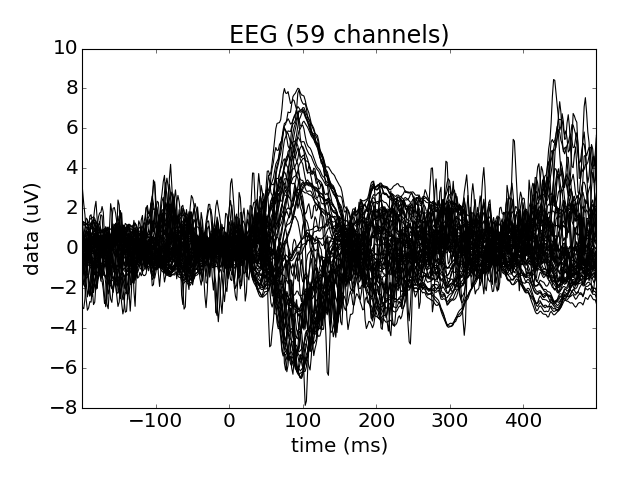

<IPython.core.display.Javascript object>


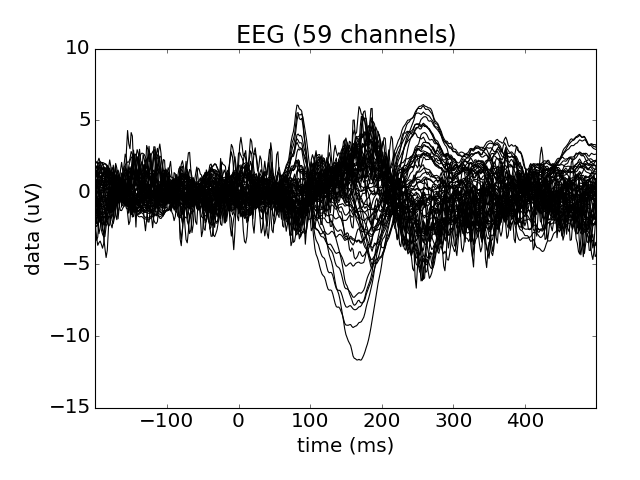

In [7]:
_ = epochs['LA'].average().plot()
_ = epochs['LV'].average().plot()

* Finally, make a `joint` plot for each condition that shows the topographies across the brain.

<IPython.core.display.Javascript object>


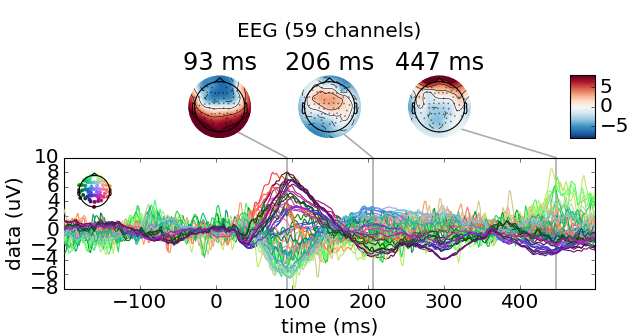

Disabling interactive colorbar for multiple axes. Turn interactivity on explicitly by passing cmap as a tuple.


/Users/choldgraf/anaconda/envs/python3/lib/python3.4/site-packages/ipykernel/__main__.py:1: RuntimeWarning: Disabling interactive colorbar for multiple axes. Turn interactivity on explicitly by passing cmap as a tuple.
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


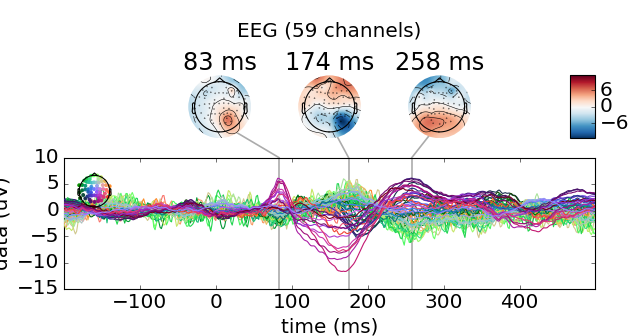

Disabling interactive colorbar for multiple axes. Turn interactivity on explicitly by passing cmap as a tuple.


/Users/choldgraf/anaconda/envs/python3/lib/python3.4/site-packages/ipykernel/__main__.py:2: RuntimeWarning: Disabling interactive colorbar for multiple axes. Turn interactivity on explicitly by passing cmap as a tuple.
  from ipykernel import kernelapp as app


In [8]:
_ = epochs['LA'].average().plot_joint()
_ = epochs['LV'].average().plot_joint()

* Does there seem to be a clear pattern on the head for each one? What about a difference in how the activity progresses in time?

# Global Field Power
It can also be useful to assess the general pattern of activity across *all* electrodes. We'll calculate this below.

* First, calculate the mean across all trials for each stimulus type. (create an `Evoked` object). Square the result.
* Calculate the mean and standard error across all channels for each `Evoked` object.

In [9]:
# First calculate the mean across trials for each stimulus type
av_a = np.mean(epochs['LA'].get_data(), 0)
av_v = np.mean(epochs['LV'].get_data(), 0)

# Now, square the values
av_a_sq = av_a ** 2
av_v_sq = av_v ** 2

# Finally, calculate the mean and standard error across electrodes
glo_a = np.mean(av_a_sq, 0)
glo_v = np.mean(av_v_sq, 0)
ste_a = nds.stats.standard_error(av_a_sq)
ste_v = nds.stats.standard_error(av_v_sq)

* Plot the mean +/- standard error for each trial type. Make them two different colors

<IPython.core.display.Javascript object>


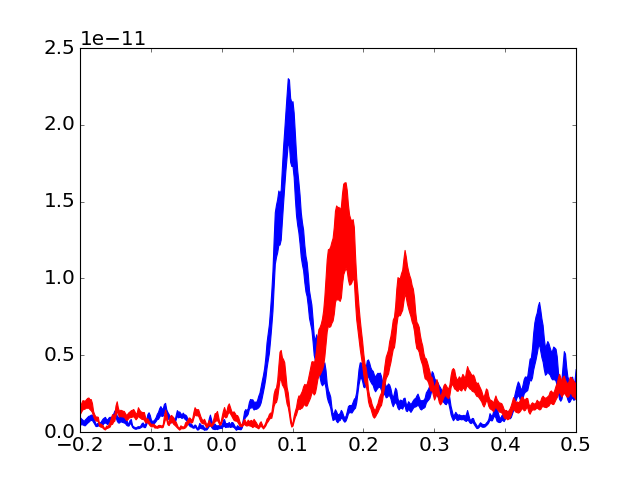

In [10]:
# Now plot the mean +/- standard error
f, ax = plt.subplots()
ax.fill_between(epochs.times, glo_a - ste_a, glo_a + ste_a, color='b')
ax.fill_between(epochs.times, glo_v - ste_v, glo_v + ste_v, color='r')

* Can you make any sense of these two patterns of activity?
* Do the plots tend to be larger or smaller in certain times over others?
* What can you say about the auditory vs. visual system from this data?

# Statistical testing
Once we've got our ERPs, it is common to test for a difference between two conditions. Here we'll make a quick attempt at doing this for the Global Field Power.

* Create a time mask for the times 90ms to 110ms after stimulus onset.
* Mask the data from each `Evoked` object, and then calculate the average across all timepoints.

In [11]:
msk_time = (epochs.times > .09) * (epochs.times < .11)

# Now, calculate the average amplitude of each channel at that time
effect_a = av_a_sq[:, msk_time].mean(axis=1)
effect_v = av_v_sq[:, msk_time].mean(axis=1)

<IPython.core.display.Javascript object>


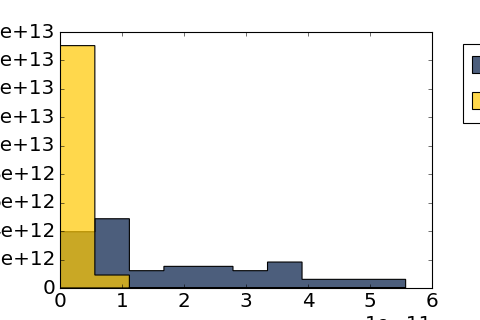

[array([  4.08804283e-12,   6.03173501e-13,   5.32605652e-13,
         1.61105751e-12,   7.49639875e-13,   4.63604776e-13,
         2.42075787e-12,   1.98338777e-12,   1.84886436e-12,
         1.20582299e-12,   1.37231280e-13,   6.46797163e-14,
         1.95661505e-13,   6.82208186e-13,   3.15914313e-12,
         1.04326992e-12,   7.98981026e-13,   4.48789170e-12,
         5.11406113e-13,   1.40331979e-13,   5.19822966e-14,
         5.99124930e-13,   1.63208937e-12,   8.08025980e-13,
         2.40846452e-12,   1.10623675e-12,   7.09593576e-13,
         1.34018744e-13,   1.23662755e-13,   2.09527548e-13,
         2.45508974e-13,   1.97068483e-13,   8.51564530e-14,
         7.83277732e-13,   1.80740090e-12,   1.33170421e-12,
         8.32573636e-13,   8.77324967e-14,   1.20855654e-13,
         8.95709091e-13,   1.10777407e-12,   7.17709208e-13,
         2.02294983e-12,   4.92122558e-13,   1.38019674e-13,
         8.84871409e-14,   4.92765071e-13,   1.29353010e-12,
         2.87438997e-12

In [12]:
# Plot a histogram of each group so that we can compare
data = ds.Table().with_columns([('a', effect_a), ('v', effect_v)])
_ = data.hist()

* Next, use a bootstrap method to put 95% confidence intervals on the difference between the two conditions.

In [13]:
n_bootstraps = 1000
n_points = data.num_rows
boot_means = np.zeros(n_bootstraps)
for ii in range(n_bootstraps):
    samp_a = data.sample(data.num_rows, with_replacement=True)['a']
    samp_v = data.sample(data.num_rows, with_replacement=True)['v']
    boot_means[ii] = samp_a.mean() - samp_v.mean()

* Finally, plot a histogram of the bootstrapped means.
* Plot vertical lines at the 95% confidence interval.

<IPython.core.display.Javascript object>


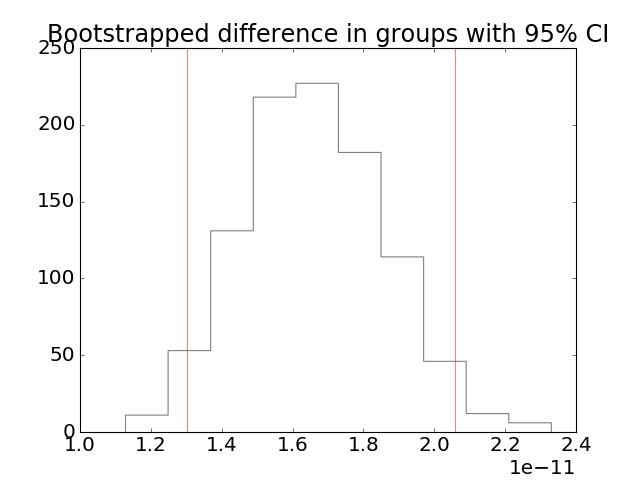

In [14]:
lo, hi = np.percentile(boot_means, [2.5, 97.5])

f, ax = plt.subplots()
ax.hist(boot_means, color='k', histtype='step', alpha=.5)
for iline in [lo, hi]:
    ax.axvline(iline, color='r', alpha=.5)
ax.set_title('Bootstrapped difference in groups with 95% CI')

* What does this distribution mean?
* Does the confidence interval overlap with zero? What does this mean?

# ERPs in ECoG
Next we'll focus on the same trial averaging approaches that we've learned about in EEG. We'll see if the same kinds of signals come out of this approach, and examine the brain activity under a slightly more complex experiment.

This dataset was recorded during a task in which subjects listened to musical chords. These chords were either consonant, or dissonant. It was used to investigate whether auditory regions of the brain change their activity in response to these different types of sounds.

* First, load in the data and event information
* Then load in the channel layout file as well as an image of the brain for plotting

In [15]:
# You should preload the data, because it takes some time to load
path_ecog = '../../data/ecog/chords_task/'
raw = mne.io.Raw(path_ecog + 'ecog_resamp-raw.fif', preload=True)
events = ds.Table.read_table(path_ecog + 'meta_time.csv', index_col=0)
lt = mne.channels.read_layout('brain', path_ecog)
im = plt.imread(path_ecog + 'brain.png')

<IPython.core.display.Javascript object>


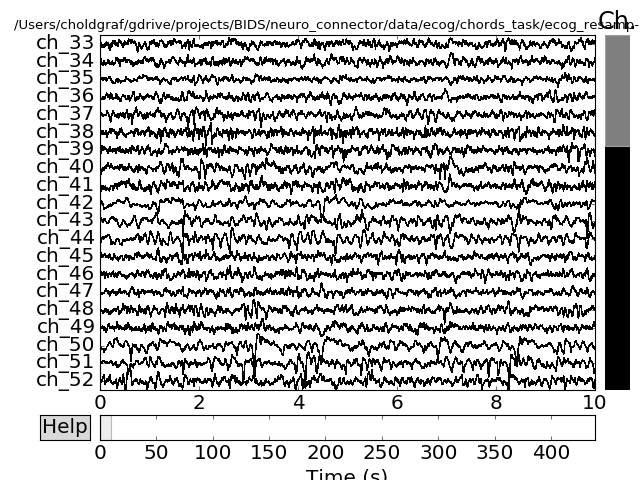

In [16]:
# Plot the raw channels and drop noisy channels
_ = raw.plot(scalings='auto')

* Look at our events object and see what kind of data we have
* Show the unique values in the `type` column to see what kinds of events exist

In [17]:
print(events)
print(np.unique(events['type']))

start   | type      | stop
4.96914 | consonant | 5.66914
10.0105 | consonant | 10.7105
28.3729 | consonant | 29.0729
47.8371 | consonant | 48.5371
58.3871 | consonant | 59.0871
65.2148 | consonant | 65.9148
75.5478 | consonant | 76.2478
81.1567 | consonant | 81.8567
84.729  | consonant | 85.429
86.5149 | consonant | 87.2149
... (95 rows omitted)
['consonant' 'dissonant' 'meow']


* It looks like we have two types of events. Create a dictionary that maps the event names to two event IDs for these events.
* Then, create a list of event IDs that maps onto the event onsets in this table. One ID for each event.

In [18]:
# Create the ID types for each event, along with a dictionary for reference
event_dict = dict(consonant=1, dissonant=2)
event_ids = events['type']
event_ids = np.where(event_ids == 'consonant', 1, 2)

* Now convert the events object into an MNE events array. Remember that the first column should be the index of when that event occurred.

In [19]:
# Turn these events into an array of indices we can use in MNE
event_ixs = events['start'] * raw.info['sfreq']
event_ixs = np.vstack([event_ixs,
                       np.zeros_like(event_ixs),
                       event_ids])
event_ixs = event_ixs.astype(int).T

* Using the `Raw` object we created, along with this events array, create an `Epochs` object. Include times from -200ms to 500ms.
* Plot the average responses for each condition

The events passed to the Epochs constructor are not chronologically ordered.


/Users/choldgraf/anaconda/envs/python3/lib/python3.4/site-packages/ipykernel/__main__.py:2: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  from ipykernel import kernelapp as app


<IPython.core.display.Javascript object>


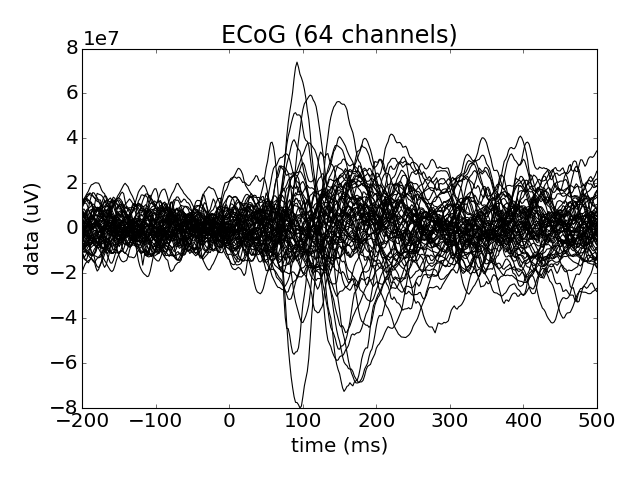

<IPython.core.display.Javascript object>


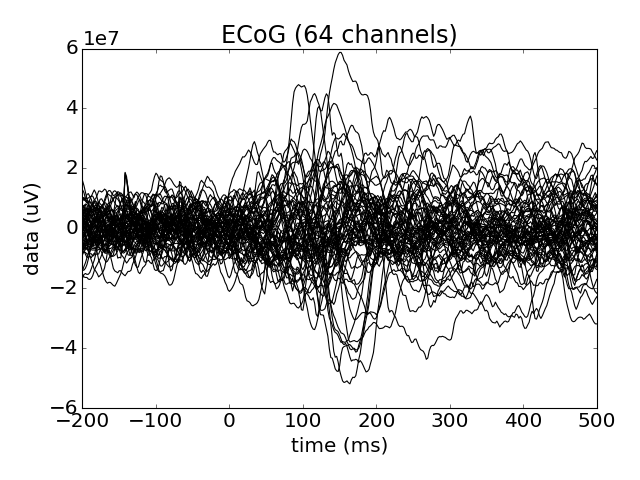

In [20]:
epochs = mne.Epochs(raw, event_ixs, event_dict,
                    tmin=-.2, tmax=.5, preload=True)


# Now calculate the average for each type of event separately
_ = epochs['consonant'].average().plot()
_ = epochs['dissonant'].average().plot()

Note that we can't make a "joint" plot for this, because each ECoG grid has a unique structure and location on the brain, so the "standard" scalp topographies won't work.

**However**, we can still plot averages using a custom topographic layout. This will give us a rough idea of where on the brain the activity exists.

* Use the `plot_topo` method of our `Evoked` object to plot the average waveform at each channel.
  * For a custom layout, use the `layout` parameter along with the layout file we loaded above
  * To plot the image of the brain as well, use the `fig_background` method and pass the image file that we loaded above

<IPython.core.display.Javascript object>


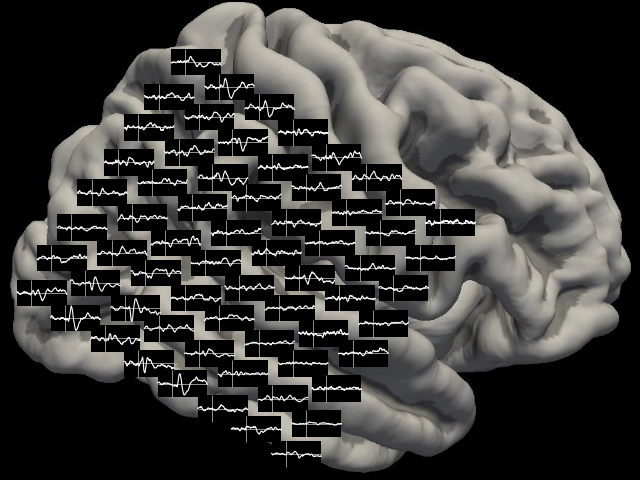

In [21]:
# However, we can still plot averages with a custom topographic layout
# Use the `plot_topo` function after averaging
# For a custom layout, use the `layout` parameter along with
# `fig_background` to show the brain in the background.
_ = epochs['consonant'].average().plot_topo(layout=lt, fig_background=im)

# Bootstrapping waveform confidence intervals
Previously we calculated the Global Field Power by combining the activity across many channels. We did this calculating the mean and standard error, which is a parametric way of assessing the variability of a signal.

Here, we'll do the same thing with the bootstrap, a resampling method that makes less assumptions about your data. It is a very flexible tool which is used extensively in neuroscience.

* Calculate the Global Field Power for each condition of our ECoG data.
* Then, use a bootstrap method to put confidence intervals on each timepoint across all 

In [22]:
# Take the average across all trials for these electrodes
av_con = np.mean(epochs['consonant']._data, 0) ** 2
av_dis = np.mean(epochs['dissonant']._data, 0) ** 2

lo_con, hi_con = nds.stats.bootstrap_func(av_con, axis=0)
lo_dis, hi_dis = nds.stats.bootstrap_func(av_dis, axis=0)

* Now, plot the activity lower and upper bound (across time) from our bootstrap results for each condition.

<IPython.core.display.Javascript object>


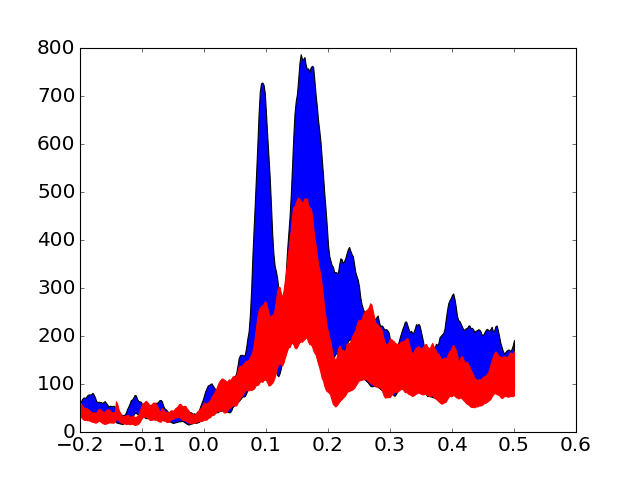

In [23]:
# Now plot the comparison
f, ax = plt.subplots()
ax.fill_between(epochs.times, lo_con, hi_con)
ax.fill_between(epochs.times, lo_dis, hi_dis, color='r')

* What can you conclude from this? 
* Is there a "difference" between these two types of chords?

# Bootstrapping a statistical test
The final part of this lab will try to determine whether there is a "real" difference between these two conditions. For a window from 200ms to 250ms post-stimulus, we'll test for the difference in average amplitude between these two groups. 

* Plot a histogram of the average amplitude within the time window (the data should be shape (n_channels,) for each condition.

In [24]:
tmin, tmax = (.2, .25)
msk_times = nds.utils.time_mask(epochs.times, tmin, tmax)
con = av_con[..., msk_times].mean(-1)
dis = av_dis[..., msk_times].mean(-1)

<IPython.core.display.Javascript object>


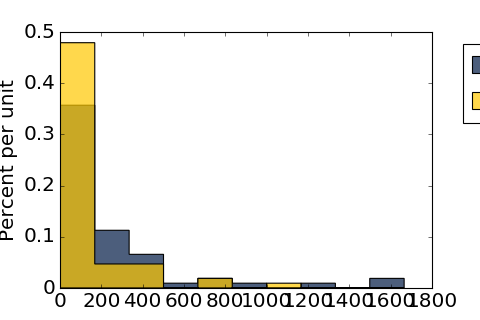

[array([  387.40662224,   141.78028393,    38.29379672,    55.80536923,
         301.07524641,    39.72407635,    19.58332616,   347.73533255,
         416.41672657,     6.67940828,    24.53447036,   164.23925835,
          38.33558027,    39.40582357,    65.38120698,   149.40882422,
          11.75580505,   337.68288201,   214.02482057,    92.4082788 ,
          72.55700704,   773.57924215,   223.05159146,   139.37024168,
          27.32986268,    18.17614944,    43.80261131,    34.30173496,
           6.79346739,     8.40391527,    16.40183461,     9.40689018,
         691.14237577,    72.80766428,    30.39515721,    24.05657347,
        1005.32770896,    71.91860411,   109.73402102,    59.76253168,
          12.92633592,    61.79634606,    55.20971   ,    29.80589472,
         100.45151219,    24.81102466,    24.47519598,   187.85665963,
          45.09630239,   177.40292575,    45.0656629 ,    85.77025337,
         121.16934587,    43.24016909,    28.38807067,    78.05500159,
     

In [25]:
boot = ds.Table().with_columns([('con', con), ('dis', dis)])
boot.hist()

* Now, using a bootstrap method: 
* Construct a 95% confidence interval for the *difference in average amplitude (across channels)* between condititions within this time window. 
* Do the same for a 99% confidence interval.
* Plot a histogram showing the bootstrap results, and vertical lines for the confidence interval. Use the color *red* for the 95% confidence interval, and *black* for the 99% confidence interval.

In [26]:
n_boots = 1000
n_rows = boot.num_rows
means = np.zeros(n_boots)
for ii in range(n_boots):
    sample_con = boot.sample(n_rows, with_replacement=True)['con']
    sample_dis = boot.sample(n_rows, with_replacement=True)['dis']
    means[ii] = sample_con.mean() - sample_dis.mean()

<IPython.core.display.Javascript object>


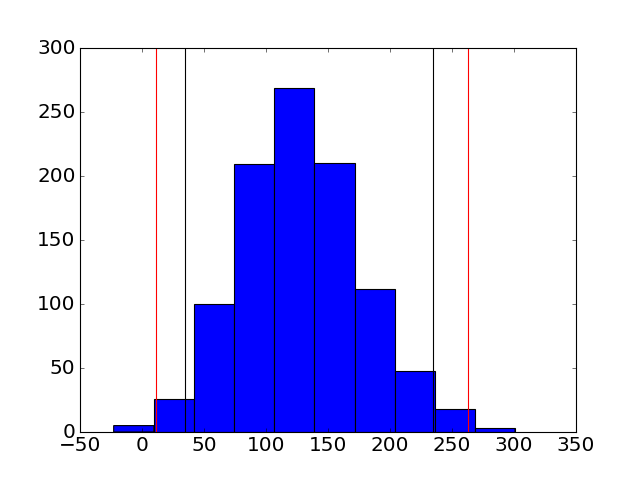

In [27]:
clo99, chi99 = np.percentile(means, [.5, 99.5])
clo95, chi95 = np.percentile(means, [2.5, 97.5])
f, ax = plt.subplots()
ax.hist(means)
for clo, chi, color in [[clo99, chi99, 'r'], [clo95, chi95, 'k']]:
    ax.axvline(clo, color=color)
    ax.axvline(chi, color=color)

* How would you describe what these bootstrap intervals mean?
* Looking at these confidence intervals, do you think there is a difference between the groups?
* Does each interval give you the same interpretation? Why or why not?